# Early Stopping

---

#### Goals

1. To understand the problem of overfitting
2. To know what countermeasures exist
3. To implement earlystopping
4. To compare early-stopped output and previous output
---

## 1. Library Importation & Device Preparation

In [1]:
# You don't need to edit this section today.
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from IPython.display import clear_output
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torchsummary import summary as Summary
from torchvision.datasets import CIFAR10

from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip, \
                                   Resize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'{"CPU" if device == "cpu" else "GPU"} will be used in training/validation.')

GPU will be used in training/validation.


## 2. Hyper-parameters

By executing below blocks, you can initialize/update hyper-parameters.

In [2]:
# Data Load
input_norm_mean = (.4914, .4822, .4465)
input_norm_std = (.2023, .1994, .2010)
batch_size = 2000

# Learning
logging_dispfig = True
earlystop_patience = 40
learning_rate = 0.004

## 3. Data Load & Preprocessing

Today we will use CIFAR-10 dataset with data augmentation.

![CIFAR-10 examples](https://monet.postech.ac.kr/~wldh/CIFAR10.svg)

In [3]:
# Load dataset into python variable
input_transform = transforms.Compose([
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(mean=input_norm_mean, std=input_norm_std),
])

train_data = CIFAR10("./", train=True, transform=input_transform, download=True)
train_data, valid_data = random_split(train_data, [2000, 48000])
valid_data, trash_data = random_split(valid_data, [2000, 46000])
test_data = CIFAR10("./", train=False, transform=input_transform, download=False)

# Create data loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=len(valid_data), pin_memory=True)
test_loader = DataLoader(test_data, batch_size=len(test_data), pin_memory=True)

Files already downloaded and verified


## 4. Function Definitions

Because our model is too simple now, we will use just `nn.Linear` module and wrap it with initializer function instead of defining a model class.

In [4]:
# Model
def init_model():
    global net, best_net, loss_fn, optim
    net = YetAnotherCNN().to(device)
    best_net = YetAnotherCNN().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=learning_rate)


class YetAnotherCNN(nn.Module):
    """My Little Convolutional Neural Network for Active CAM, based on VGG11"""

    def __init__(self):
        super(YetAnotherCNN, self).__init__()
        self.convolution_part = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=4, stride=3)
        )
        self.classifier_part = nn.Linear(32*5*5, 10, bias=False)

    def forward(self, data):
        conv_out = self.convolution_part(data)
        conv_out_flatten = conv_out.reshape(conv_out.size(0), -1)
        return self.classifier_part(conv_out_flatten)
        #return conv_out


# Model structure check
Summary(YetAnotherCNN().to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         LeakyReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 32, 16, 16]           9,248
       BatchNorm2d-6           [-1, 32, 16, 16]              64
         LeakyReLU-7           [-1, 32, 16, 16]               0
         MaxPool2d-8             [-1, 32, 5, 5]               0
            Linear-9                   [-1, 10]           8,000
Total params: 18,272
Trainable params: 18,272
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.01
Params size (MB): 0.07
Estimated Total Size (MB): 1.09
---------------------------------------------

In [5]:
# Epoch
def init_epoch():
    global epoch_cnt, earlystop_cnt
    epoch_cnt = 0
    earlystop_cnt = 0


def epoch(data_loader):
    # One epoch : gets data_loader as input and returns loss / accuracy, and
    #             last prediction value / its label(truth) value for future use
    global epoch_cnt
    iter_loss, iter_acc = [], []

    last_grad_performed = False

    # Mini-batch iterations
    for _data, _label in data_loader:
        data, label = _data.to(device), _label.to(device)

        # 1. Feed-forward
        onehot_out = net(data)

        # 2. Calculate accuracy
        _, out = torch.max(onehot_out, 1)
        acc_partial = (out == label).float().sum()
        acc_partial = acc_partial / len(label)
        iter_acc.append(acc_partial.item())

        # 3. Calculate loss
        loss = loss_fn(onehot_out, label)
        iter_loss.append(loss.item())

        # 4. Backward propagation if not in `torch.no_grad()`
        if onehot_out.requires_grad:
            optim.zero_grad()
            loss.backward()
            optim.step()
            last_grad_performed = True

    # Up epoch count if backward propagation is done
    if last_grad_performed:
        epoch_cnt += 1
    
    return np.average(iter_loss), np.average(iter_acc)


def epoch_not_finished():
    return earlystop_cnt < earlystop_patience

In [6]:
# Earlystopping
def copy_weights(src, dst):
    dst.load_state_dict(src.state_dict())

In [7]:
# Logging
def init_log():
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []


def record_train_log(_tloss, _tacc, _time):
    # Push time, training loss, training accuracy, and epoch count into lists
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)


def record_valid_log(_vloss, _vacc):
    # Push validation loss and validation accuracy into each list
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)


def last(log_list):
    # Get the last member of list. If empty, return -1.
    if len(log_list) > 0: return log_list[len(log_list) - 1]
    else: return -1


def print_log():
    # Generate log string and put it into log stack
    log_str = f'Iter: {last(iter_log):>4d} >> T_loss {last(tloss_log):<8.5f}   ' \
            + f'T_acc {last(tacc_log):<6.5f}   V_loss {last(vloss_log):<8.5f}   ' \
            + f'V_acc {last(vacc_log):<6.5f}   🕒 {last(time_log):5.3f}s'
    if earlystop_cnt > 0:
        log_str += f' | es_cnt = {earlystop_cnt}'
    log_stack.append(log_str)
  
    # Draw figure if want
    if logging_dispfig:
        hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99)
        hist_fig.patch.set_facecolor('white')

        # Draw loss lines
        loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color='#FF9999', marker='o')
        loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color='#99B0FF', marker='s')
        loss_axis.set_xlabel('epoch')
        loss_axis.set_ylabel('loss')

        # Draw accuracy lines
        acc_axis = loss_axis.twinx()
        acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc.', color='#FF0000', marker='+')
        acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc.', color='#003AFF', marker='x')
        acc_axis.set_ylabel('accuracy')

        # Append annotations
        hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line
        loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines])
        loss_axis.grid()
        plt.title(f'Learning history until epoch {last(iter_log)}')
        plt.draw()

    # Print log
    clear_output(wait=True)
    if logging_dispfig: plt.show()
    if earlystop_cnt > 0:
        print(f'Current earlystop count = {earlystop_cnt} / {earlystop_patience}')

## 5. Training Iteration

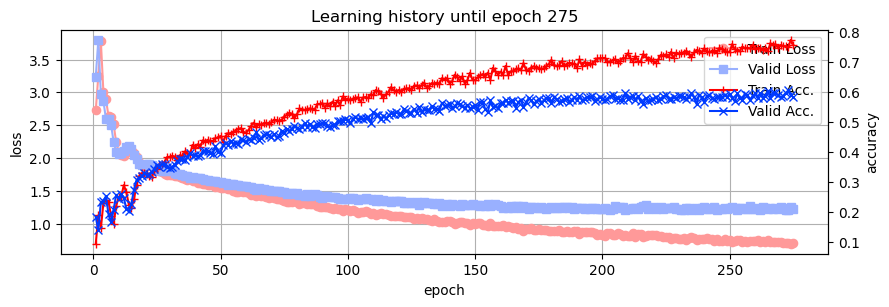

Current earlystop count = 40 / 40

 Training completed

Iter:  275 >> T_loss 0.70310    T_acc 0.75950   V_loss 1.22068    V_acc 0.58450   🕒 0.406s | es_cnt = 40
Iter:  274 >> T_loss 0.69448    T_acc 0.77500   V_loss 1.25337    V_acc 0.59050   🕒 0.406s | es_cnt = 39
Iter:  273 >> T_loss 0.70903    T_acc 0.75000   V_loss 1.21260    V_acc 0.60650   🕒 0.408s | es_cnt = 38
Iter:  272 >> T_loss 0.70432    T_acc 0.75350   V_loss 1.21329    V_acc 0.59700   🕒 0.406s | es_cnt = 37
Iter:  271 >> T_loss 0.70905    T_acc 0.75550   V_loss 1.23387    V_acc 0.58850   🕒 0.405s | es_cnt = 36
Iter:  270 >> T_loss 0.72334    T_acc 0.75800   V_loss 1.24798    V_acc 0.58350   🕒 0.406s | es_cnt = 35
Iter:  269 >> T_loss 0.71898    T_acc 0.74950   V_loss 1.22036    V_acc 0.59050   🕒 0.407s | es_cnt = 34
Iter:  268 >> T_loss 0.71785    T_acc 0.76100   V_loss 1.23519    V_acc 0.59700   🕒 0.410s | es_cnt = 33
Iter:  267 >> T_loss 0.72324    T_acc 0.75700   V_loss 1.22801    V_acc 0.59850   🕒 0.447s | es_cnt = 32

In [8]:
# Training Initialization
init_model()
init_epoch()
init_log()

# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc = epoch(train_loader)
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc = epoch(valid_loader)
        if len(vloss_log) and np.min(vloss_log) < vloss:
            earlystop_cnt = earlystop_cnt + 1
        else:
            earlystop_cnt = 0
            copy_weights(net, best_net)
        record_valid_log(vloss, vacc)
    print_log()

copy_weights(best_net, net)

print('\n Training completed\n')
for idx in reversed(range(len(log_stack))):
    print(log_stack[idx])

## 6. Result Analysis

In this section, we will calculate accuracy.

In [9]:
# Accuracy for test dataset
with torch.no_grad():
    test_loss, test_acc = epoch(test_loader)
    print(f'Test accuracy = {test_acc}\nTest loss = {test_loss}')

Test accuracy = 0.5891000032424927
Test loss = 1.2053977251052856


## 7. Saving Model

Are you satisfied with your model? Then save it!

In [10]:
torch.save(net, './model.pkl')

If you want to load your model, enter below.

In [11]:
net = torch.load('./model.pkl')